In [2]:
from hacca import hacca
from typing import Tuple, Union
import scanpy as sc
from sklearn.cross_decomposition import CCA
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.spatial import cKDTree
import ot
from collections import Counter
from hacca.data import Data
import cv2
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os

In [13]:
#### dir name
cwd="I:\\mutiomics\\"
data_path = os.path.join(cwd, '..', 'data')
work_dir = os.path.join(cwd, '..', 'work')
if not os.path.exists(work_dir):
    os.makedirs(work_dir)
####read in data align b_prime to a. in this case, a is MSI-MALDI and b_prime is 10X Visum.
a_h5ad = sc.read_h5ad("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\m3_9AA_VisiumArray.h5ad")
b_prime_h5ad = sc.read_h5ad("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\m3_visium_ctrl.h5ad")
##data preprocession. MSI-MALDI has a blank area, clustered as cluster 0, remove it
a_h5ad.obs["leiden"] = a_h5ad.obs["clusters"]
b_prime_h5ad.obs["leiden"] = b_prime_h5ad.obs["clusters"]
idx_to_remove = a_h5ad.obs["clusters"][a_h5ad.obs["clusters"] == "0"]
keep_cells_mask = ~a_h5ad.obs.index.isin(idx_to_remove.index)
a_h5ad = a_h5ad[keep_cells_mask, :]

In [14]:
##lets take a look at a and b_prime
print("a",a_h5ad)
print("b_prime",b_prime_h5ad)

a View of AnnData object with n_obs × n_vars = 3084 × 3658
    obs: 'clusters', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
b_prime AnnData object with n_obs × n_vars = 2239 × 15249
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'n_genes', 'clusters', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


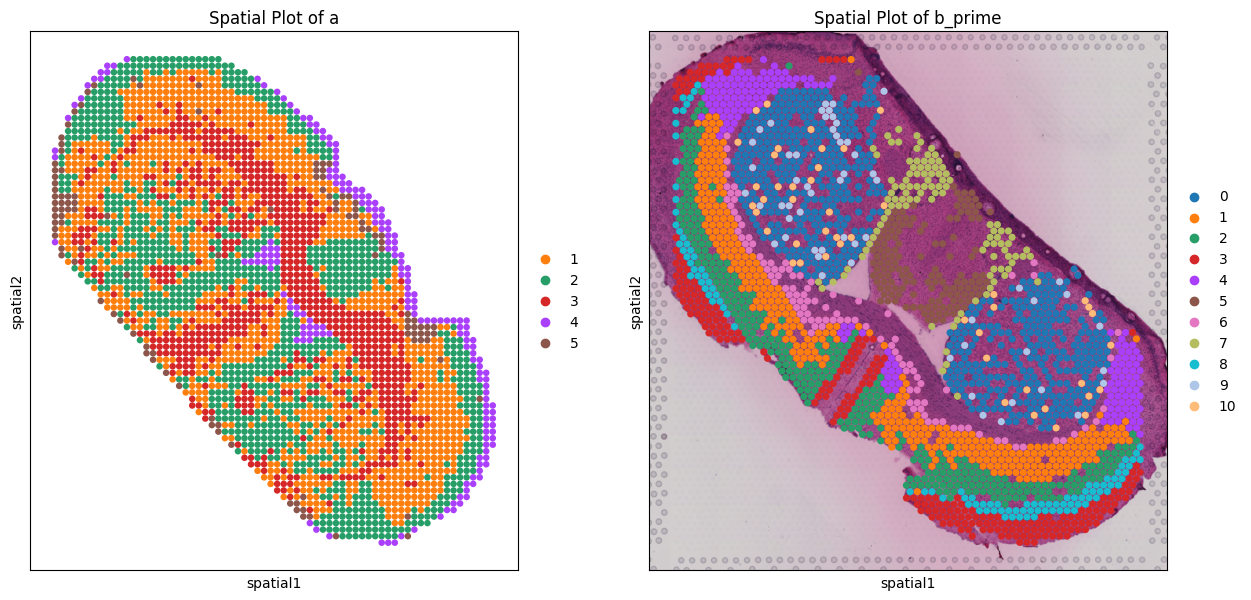

In [15]:
##lets take a look at a and b_prime
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sc.pl.spatial(a_h5ad, img_key = "hires", color="clusters", spot_size=1, ax=axs[0], show=False)
axs[0].set_title('Spatial Plot of a')
sc.pl.spatial(b_prime_h5ad, img_key = "hires", color="clusters", size=1.5,ax=axs[1],show=False)
axs[1].set_title('Spatial Plot of b_prime')
plt.show()

In [16]:
#### scale spatial data of a and b_prime
b_prime_spatial = pd.DataFrame(b_prime_h5ad.obsm['spatial'])
scaledata = hacca.center_and_scale(b_prime_spatial)
b_prime_spatial = pd.DataFrame(scaledata, columns=b_prime_spatial.columns).to_numpy()
a_spatial = pd.DataFrame(a_h5ad.obsm['spatial'])
scaledata = hacca.center_and_scale(a_spatial)
a_spatial = pd.DataFrame(scaledata, columns=a_spatial.columns).to_numpy()

In [25]:
# turn a and b_prime into hacca.Data format:Data(X(n,m),D(n,2),Lable(n,1)). n is the number of spots and m is the number of features
a = Data(X=a_h5ad.X.toarray(), D = a_spatial, Label=a_h5ad.obs['leiden'].to_numpy())
b_prime = Data(X=b_prime_h5ad.X.toarray(), D = b_prime_spatial, Label=b_prime_h5ad.obs['leiden'].to_numpy())

I:\mutiomics\pythonProject\hacca\hacca.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_C_.loc[:,'BprimeID'] = values
I:\mutiomics\pythonProject\hacca\hacca.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_.loc[:,'AID'] = values
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


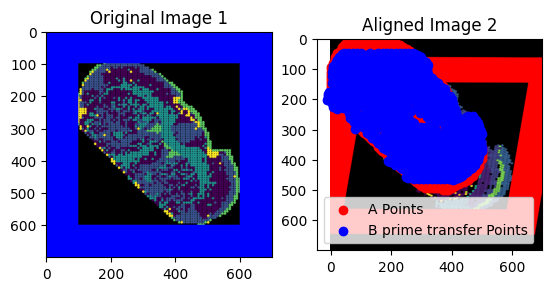

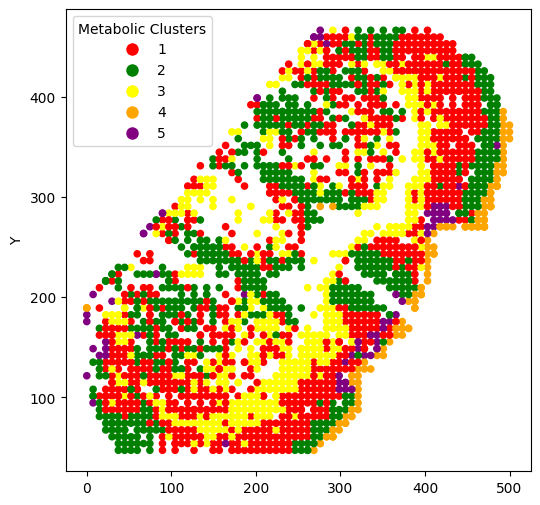

In [26]:
#ok lets hacca
#this is the classic hacca, morphopogical alignment is peformed by manual gross and further alignment,
#combined feature and morphological alignment is performed by ICP
manual_gross_further_ICP_work_dir = os.path.join(work_dir, 'manual_gross_further')
if not os.path.exists(manual_gross_further_ICP_work_dir):
    os.makedirs(manual_gross_further_ICP_work_dir)
##gross manual alignment
_b_prime = hacca.manual_gross_alignment(a, b_prime, work_dir=manual_gross_further_ICP_work_dir)
##further alignment 
_b_prime = hacca.further_alignment(a, _b_prime)
##combined feature and morphological alignment
_a, _b_prime = hacca.icp_3d_alignment(a, _b_prime)
b_predict = hacca.direct_alignment(_a, _b_prime, work_dir=manual_gross_further_ICP_work_dir)
##b_predict is the aligned b_prime
hacca.plot_b_predict(b_predict,manual_gross_further_ICP_work_dir)

In [27]:
##lets merge b_prime and b_predict
Label_merge = np.vstack((b_prime.Label,b_predict.Label)).T
Label_merge = pd.DataFrame(Label_merge,columns=["b_prime_label","a_label"])
X_merge = np.hstack((b_prime.X,b_predict.X))
merge_var = np.hstack((b_prime_h5ad.var_names, a_h5ad.var_names))
merge_var = pd.DataFrame(index=merge_var)

In [28]:
##generating a new merge_adata
merge_adata = sc.AnnData(X=X_merge, var=merge_var, obs=Label_merge)
merge_adata.obsm=b_prime_h5ad.obsm
merge_adata.uns =b_prime_h5ad.uns

I:\mutiomics\pythonProject\.venv\lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


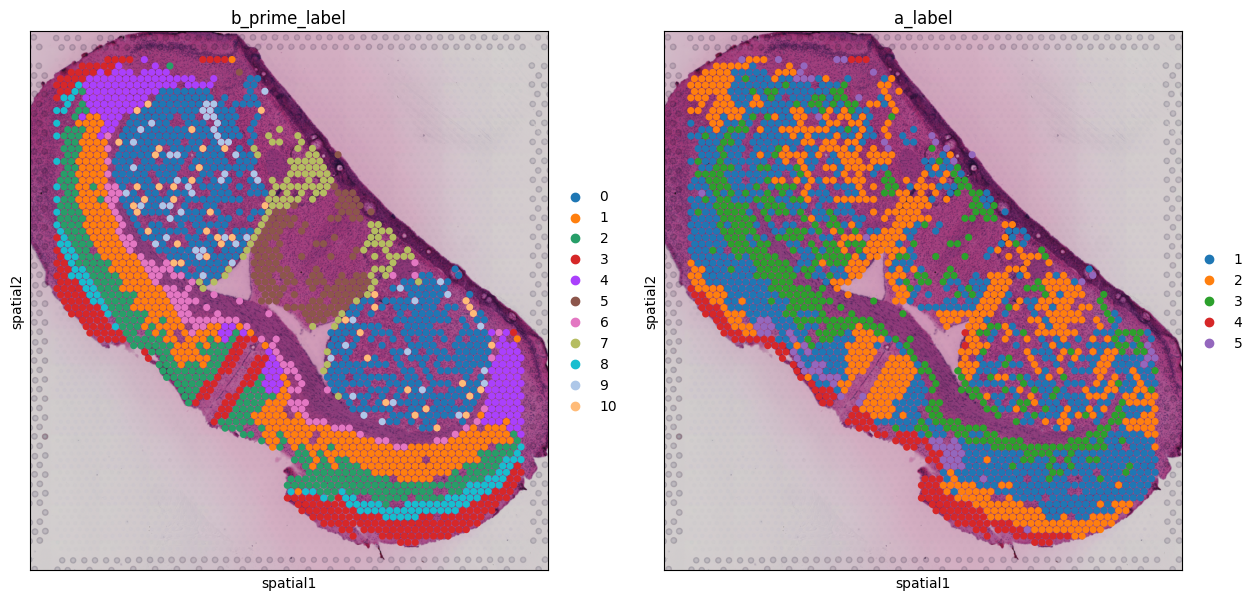

In [29]:
##lets take a look at b_prime and a's label distribution in merge_adata
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sc.pl.spatial(merge_adata, img_key = "hires", color="b_prime_label", size=1.5,ax=axs[0],show=False)
axs[0].set_title('b_prime_label')
sc.pl.spatial(merge_adata, img_key = "hires", color="a_label", size=1.5,ax=axs[1],show=False)
axs[1].set_title('a_label')
plt.show()

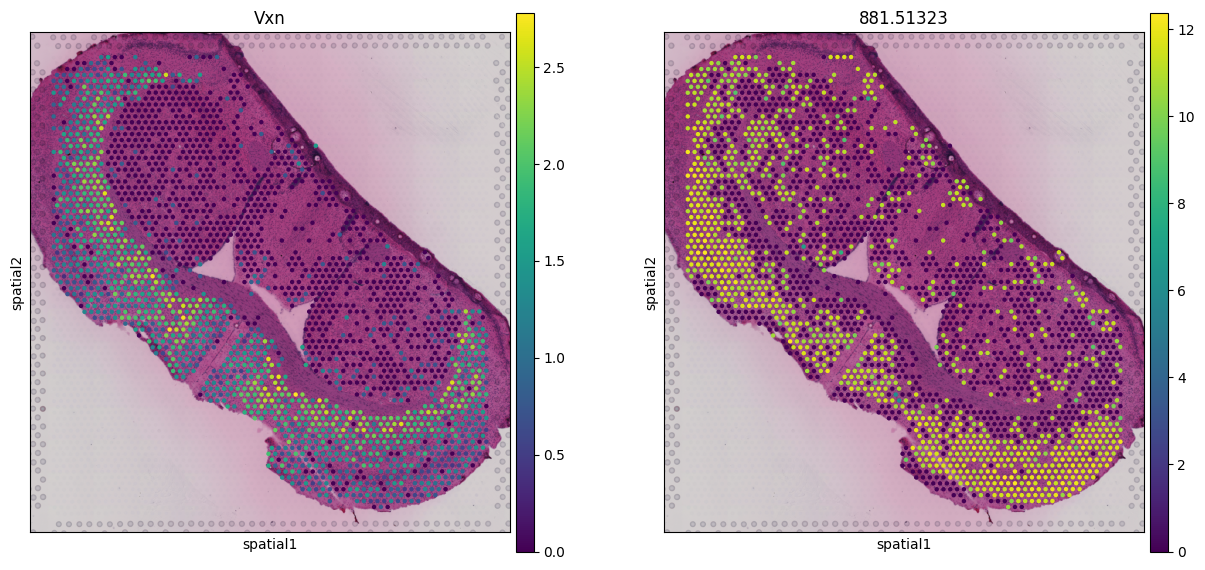

In [24]:
##lets take a look at b_prime and a's feature distribution in merge_adata
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sc.pl.spatial(merge_adata,color="Vxn",title="Vxn",size=1,show=False, alpha_img=1,ax=axs[0])
sc.pl.spatial(merge_adata,color="881.51323",title="881.51323",size=1,show=False, alpha_img=1,ax=axs[1])
plt.show()
